# 문서 유사도 측정 방법 - 코사인 유사도
#### 문서와 문서 간의 유사도 비교는 일반적으로 코사인 유사도를 사용한다.
#### 코사인 유사도는 벡터의 크기보다는 벡터의 상호 방향성이 얼마나 유사한지에 기반한다. 즉, 두 벡터 사이의 사잇각을 구해서 얼마나 유사한지 수치로 적용한 것이다.
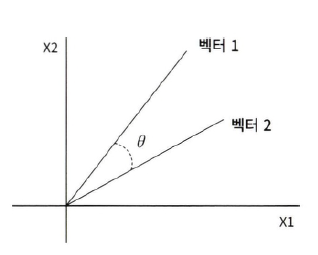

## 두 벡터 사잇각
#### 두 벡터의 사잇각에 따라 상호 관계가 아래와 같이 형성된다.
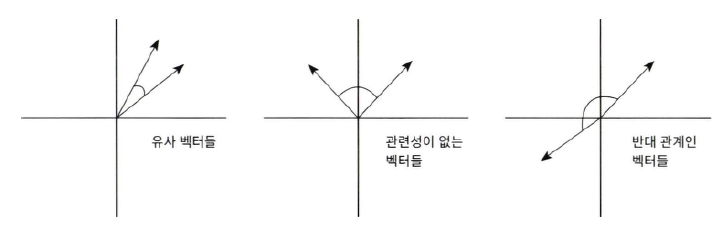

#### 유사도 cos8는 다음과 같이 두 벡터의 내적을 총 벡터 크기의 합으로 나눈 것이다.
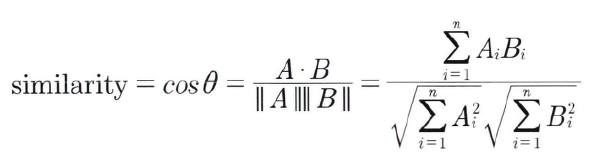

In [1]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm
    
    return similarity

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


#### 반환된 행렬은 희소 행렬이므로 앞에서 작성한 cos_similarity() 함수의 인자인 array로 만들기 위해 밀집 행렬로 변환한 뒤 다시 각각의 배열로 변환한다.
#### 첫 번째 문장과 두 번째 문장의 문서 유사도를 측정해보자

In [4]:
# 희소 행렬 -> 밀집 행렬
feature_vect_dense = feature_vect_simple.todense()

# 첫/두 번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

similarity_simple = cos_similarity(vect1, vect2)
print(similarity_simple)

0.4020775821495014


In [5]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


#### 사이킷런은 코사인 유사도를 측정하기 위해 sklearn.metrics.pairwise.cosine_similarity api를 사용해서 문서 유사도를 측정할 수 있다.
#### 해당 api는 희소 행렬, 밀집 행렬 모두가 가능하며, 행렬 또는 배열 모두 가능하다. 따라서 앞에서 만든 함수처럼 별도의 변환 작업이 필요 없다.

#### 첫 번째 문서와 자기 자신을 포함한 나머지 문서들과의 유사도 측정

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


#### 첫 번째 문서와 나머지 문서와의 유사도 측정(자기 자신 제외)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


#### 모든 개별 문서에 대한 쌍의 유사도 측정

In [8]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


## Opinion Review 데이터 세트를 이용한 문서 유사도 측정
#### 새롭게 DataFrame으로 로드하고 문서 군집화를 적용해보자

In [9]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환. 
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환. 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [12]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

#path = r'C:\Users\q\Text\OpinosisDataset1.0\OpinosisDataset1.0\topics'
path = r'C:\machine_learning_guide\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

#### 해당 문서의 군집화는 전자제품, 호텔, 자동차를 주제로 군집화되었다.
#### 이 중 호텔의 주제로 군집화된 문서를 이용해 특성 문서와 다른 문서 간의 유사도를 알아보자
#### document_df에서 먼저 호텔로 군집화된 문서의 인덱스를 추출합니다. 추출된 인덱스를 그대로 이용해 TfidfVectorizer 객체 변수인 feature_vect에서 호텔로 군집화된 문서의 피처 벡터를 추출한다.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==2].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')
##### 비교 기준 문서명  bathroom_bestwestern_hotel_sfo  와 타 문서 유사도######
[[1.         0.0430688  0.05221059 0.06189595 0.05846178 0.06193118
  0.03638665 0.11742762 0.38038865 0.32619948 0.51442299 0.11282857
  0.13989623 0.1386783  0.09518068 0.07049362]]


가장 유사도가 큰 파일명 및 유사도:
 filename      room_holiday_inn_london
similarity                   0.514423
Name: 32, dtype: object


Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

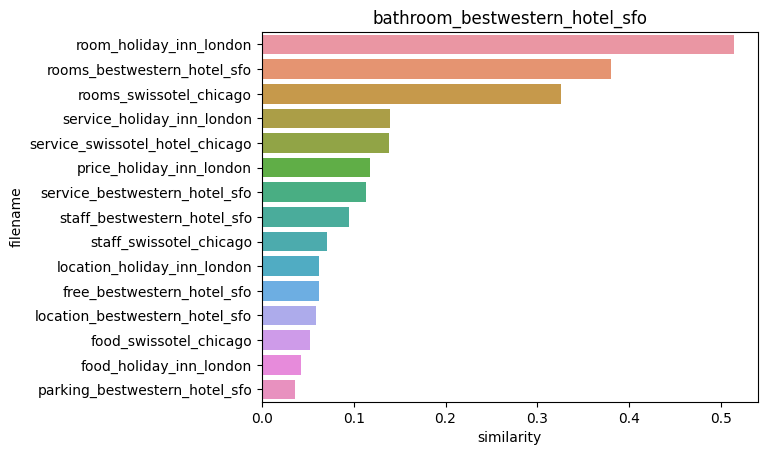

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 추출하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value
print('가장 유사도가 큰 파일명 및 유사도:\n', hotel_1_sim_df.iloc[0, :])

sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)